# DSP305X Project - Horse Betting

# I. Load Data

In [4]:
## TYPE YOUR CODE for task 2 here:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [150]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.metrics import precision_score, classification_report, confusion_matrix
RA = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/RA.pickle').reset_index(drop=True)#Race details
SE = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/SE.pickle').reset_index(drop=True)#Horse race information
UM_all = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/UM_all.pickle').reset_index(drop=True)#thông tin con ngựa
WE = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/WE.pickle').reset_index(drop=True)#weather
BN = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/BN.pickle').reset_index(drop=True)#BANUSI, người sở hữu
BR = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/BR.pickle').reset_index(drop=True)#BREEDER, nơi huấn luyện
CH = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/CH.pickle').reset_index(drop=True)#CHOKYO, trainer
HN_all = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/HN_all.pickle').reset_index(drop=True)#HANSYOKU, giống ngựa
KS = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSP305x/KS.pickle').reset_index(drop=True)#KISYU, người cưỡi ngựa

# II. Data Preprocessing

1. Duplicated value handling.

In [151]:
# unique values( delete duplicates, lay latest one), _merge increasing large of rows
# RA.isnull().any()#35925 
# RA_duplicate = RA[RA.duplicated(subset=['id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji','id$RaceNum'], keep=False)]#no duplicates found
# SE.isnull().any()
# SE_duplicate = SE[SE.duplicated(subset=['id$JyoCD','id$Year', 'id$Kaiji', 'id$Nichiji','id$RaceNum', 'KettoNum'], keep=False)]#34, keep False means show all
SE = SE.drop_duplicates(subset=['id$JyoCD','id$Year', 'id$Kaiji', 'id$Nichiji','id$RaceNum', 'KettoNum'],keep='first').reset_index(drop=True)#original:1742, unique: 1384
# UM_all.isnull().any()
# UM_duplicate = UM_all[UM_all.duplicated(subset=['KettoNum','ChokyosiCode'], keep=False)]#, keep False means show all
UM_all = UM_all.drop_duplicates(subset=['KettoNum','ChokyosiCode'],keep='first').reset_index(drop=True)#original:, unique: , da giai quyet van de thoi gian
# CH.isnull().any()
CH= CH.drop_duplicates(subset='ChokyosiCode',keep='first').reset_index(drop=True)#original:5142, unique: 1353
# KS.isnull().any()
KS = KS.drop_duplicates(subset='KisyuCode',keep='first').reset_index(drop=True)#original:1742, unique: 1384

2. Outlier Handling.

In [152]:
#xử lý outlier Futan( 4), BaTaijyu( 0,999), odds( 9999)
# Futan: already handled from duplicated value handling.
SE['BaTaijyu'] = pd.to_numeric(SE['BaTaijyu'])
SE.BaTaijyu[(SE.BaTaijyu == 999) | (SE.BaTaijyu == 0)] = SE.BaTaijyu.mean()
SE.Odds[SE.Odds == 9999] = SE.Odds.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


3. Feature selection and merging.

In [215]:
def get_data_from_feature_sel_merg(RA, SE, UM_all, CH, KS, with_new_features):
  #join: Year, JyoCD, Kaiji, Nichiji, RaceNum
  #TokuNum( cuộc thi đặc biệt không)
  #tra kq: year month day, Kaiji( giải đua), JyoCD( trường đua), TokuNum( co phai cuoc dua dac biet hay khong), KigoCD( race code, cua dua toan ngua duc cai thien), TenkoCD( code weather), SyubetuCD( race nay cho ngua bn tuoi), JyuryoCD( cach tinh weight ngua trong cd), TrackCD( loai san), SibaBabaCD( tinh trang san co), DirtBabaCD( tt san dat), Kyori( khoảng cách cuộc đua)
  RA_data = RA[['id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji','id$RaceNum','TenkoBaba$TenkoCD', 'JyokenInfo$SyubetuCD', 'JyokenInfo$KigoCD'
                , 'Kyori', 'TrackCD','TenkoBaba$SibaBabaCD', 'TenkoBaba$DirtBabaCD','GradeCD', 'RaceInfo$Nkai']]
  #KakuteiJyuni( kết quả), ninki( trình tự yêu thích), Umaban( số của con ngựa, số vào làn trong trận), Barei( tuổi ngựa), Futan( khổi lượng đảm nhiệm đai + người cưỡi), Blinker( nịt che mắt của ngựa), BaTaijyu( khối lượng ngựa), ZogenFugo( ký hiệu tăng giảm khổi lượng), Odds( win odd), Ninki( trình tự yêu thích theo người dùng, !trước vàu sau), Futan( khoi luong dam nhiem dai + nguoi cuoi)
  #Bamei( tên ngựa), id$Year Month Day( thời gian tổ chức), Kaiji( 1 năm tổ chức bao lần), Nichiji( ngày tổ chức thứ N), id$RaceNum, ..ChokyosiRyakusyo( viết tắt tên hlv), BanusiName( chủ ngựa), NyusenJyuni( ?trình tự vào làn TH ko đủ tiêu chuẩn, giống KakuteiJyuni)
  #Có thể chuyển thành categorical value #định lượng: TenkoCD( code weather cua race), JyoCD( code trường đua), UmaKigoCD( code loại ngựa), SexCD( code giới tính), ChokyosiCode( code hlv trainer master), KisyuCode( code jockey), IJyoCD( code phân loại bất thường), 
  #điều chỉnh: Ninki( bỏ),KeiroCD( tóc ngựa, cũng thể hiện được giống ngựa ví như người da đen hay người da vàng thì người da đen thường trâu hơn)
  #join: Year, JyoCD, Kaiji, Nichiji, RaceNum, KettoNum
  SE_data = SE[['Umaban','id$JyoCD','id$Year', 'id$Kaiji', 'id$Nichiji','id$RaceNum', 'KettoNum','ChokyosiCode', 'SexCD', 'Barei', 'KakuteiJyuni','Futan' ,
              'Blinker','BaTaijyu','Odds','KeiroCD',
              'UmaKigoCD', 'KisyuCode']]
  #join( nen la code/id): KettoNum, ChokyosiCode( 1 ngua co the co 2 trainer khac nhau)
  #HansyokuMochiKubun( ngựa trong nước hay nhập khẩu), SanchiName( gốc), HinsyuCD( product code về giống thuần chủng or not), ?ChokyosiCode( code trainer), ?BreederCode( nguoi nuoi), ?BanusiCode( nguoi chu) ,RaceCount( Number of races registered in JRA-VAN)
  #datakubun( thông tin update), 
  UM_data = UM_all[['KettoNum','ChokyosiCode' , 'SanchiName', 'HinsyuCD']]#thông tin con ngựa
  #join: ChokyosiCode
  #ChokyosiCode( code trainer), SexCD, TozaiCD( code xuất thân)
  CH_data = CH[['ChokyosiCode','SexCD', 'TozaiCD']]#trainer

  #join: KisyuCode( UM-KS)
  #SikakuCD( khả năng chạy đường đất phẳng chướng ngại vật), TozaiCD( code xuất thân), MinaraiCD( thành tích),
  #632 columns
  KS_data = KS[['KisyuCode','SikakuCD', 'TozaiCD', 'MinaraiCD']]#jockey
  #for improvement
  if with_new_features:  
    #replace the old one
    RA_data = RA[['id$MonthDay','id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji','id$RaceNum','TenkoBaba$TenkoCD', 'JyokenInfo$SyubetuCD', 'JyokenInfo$KigoCD'
                , 'Kyori', 'TrackCD','TenkoBaba$SibaBabaCD', 'TenkoBaba$DirtBabaCD','GradeCD', 'RaceInfo$Nkai']]
   
  RA_SE = pd.merge(RA_data, SE_data, on=['id$Year', 'id$JyoCD','id$Kaiji', 'id$Nichiji','id$RaceNum'], how='inner')#'id$DayMonth','id$DayMonthYear','DayMonthYear','YearMonthDay',
  RA_SE_UM = pd.merge(RA_SE, UM_data, on=['KettoNum','ChokyosiCode'], how='inner')#UM_data[UM_data.KettoNum==2015102976]
  RA_SE_UM_CH = pd.merge(RA_SE_UM, CH_data, on=['ChokyosiCode'], how='inner')
  RA_SE_UM_CH_KS = pd.merge(RA_SE_UM_CH, KS_data, on=['KisyuCode'], how='inner')
  return RA_SE_UM_CH_KS
data = get_data_from_feature_sel_merg(RA, SE, UM_all, CH, KS, False)

4. Data transformation and preparation for training.

In [209]:
def get_transformation_and_splitting_dropping( data, is_training, with_new_features):
  #transform/ impute data 
  def result_impute(cols):
      if cols in [1,2,3]:
          return 1
      else: 
          return 0
  data.KakuteiJyuni = data.KakuteiJyuni.apply(result_impute)
  #one-hot encoding: TenkoBaba$TenkoCD, JyokenInfo$KigoCD, JyokenInfo$JyuryoCD, TrackCD, TenkoBaba$SibaBabaCD, TenkoBaba$DirtBabaCD, SexCD_x, Blinker, UmaKigoCD, BreederCode, SanchiName, HinsyuCD, Address, SexCD_y, TozaiCD_x, SikakuCD, TozaiCD_y, MinaraiCD
  # data = pd.get_dummies(data=data, columns=['TenkoBaba$TenkoCD', 'JyokenInfo$KigoCD', 'TrackCD', 'TenkoBaba$SibaBabaCD', 'TenkoBaba$DirtBabaCD', 'SexCD_x', 'Blinker', 'UmaKigoCD', 'BreederCode', 'SanchiName', 'HinsyuCD', 'Address', 'SexCD_y', 'TozaiCD_x', 'SikakuCD', 'TozaiCD_y', 'MinaraiCD'])
  le = LabelEncoder()
  for col in ['GradeCD','JyokenInfo$KigoCD','JyokenInfo$SyubetuCD','KeiroCD','TenkoBaba$TenkoCD', 'TrackCD', 'TenkoBaba$SibaBabaCD','TenkoBaba$DirtBabaCD', 'SexCD_x', 'Blinker', 'UmaKigoCD', 'SanchiName', 'HinsyuCD', 'SexCD_y', 'TozaiCD_x', 'SikakuCD', 'TozaiCD_y', 'MinaraiCD']:
    data[col] = le.fit_transform(data[col])#convert to numeric type( category for old ones)
  # parse to numeric data
  is_baTaijyu_numeric =  data['BaTaijyu'][10].isnumeric()
  if is_baTaijyu_numeric: #random check
    data['BaTaijyu'] = pd.to_numeric(data['BaTaijyu'])
  else:
    data = data.drop(columns=['BaTaijyu'], inplace=False)#BaTaijyu contains '     '
  train_data = []
  test_data = []
  #data split
  if is_training:
      #training data
    train_data = data[data['id$Year'] != 2018]  
      #test
    test_data = data[data['id$Year'] == 2018]
    #drop unnecessary columns
    #id$Year, id$JyoCD, id$Kaiji, id$Nichiji, id$RaceNum, KettoNum, ChokyosiCode, KisyuCode
    train_data = train_data.drop(columns=['Umaban','id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji', 'id$RaceNum', 'KettoNum', 'ChokyosiCode', 'KisyuCode'], inplace=False)
    test_data = test_data.drop(columns=['Umaban','id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji', 'id$RaceNum','KettoNum', 'ChokyosiCode', 'KisyuCode'], inplace=False)
    #__for improvement
    if with_new_features:
      #drop more date
      train_data = train_data.drop(columns=['id$DayMonth','id$MonthDay','id$DayMonthYear','DayMonthYear','YearMonthDay'], inplace=False)
      test_data = test_data.drop(columns=['id$DayMonth','id$MonthDay','id$DayMonthYear','DayMonthYear','YearMonthDay'], inplace=False)
  else: #for prediction
    data = data.drop(columns=['Umaban','id$Year', 'id$JyoCD', 'id$Kaiji', 'id$Nichiji', 'id$RaceNum', 'KettoNum', 'ChokyosiCode', 'KisyuCode'], inplace=False)
    if with_new_features:
      #drop more date
      data = data.drop(columns=['id$DayMonth','id$MonthDay','id$DayMonthYear','DayMonthYear','YearMonthDay'], inplace=False)
  return train_data, test_data, data
train_data, test_data, data = get_transformation_and_splitting_dropping( data, True, False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0    156577
1     40300
Name: KakuteiJyuni, dtype: int64

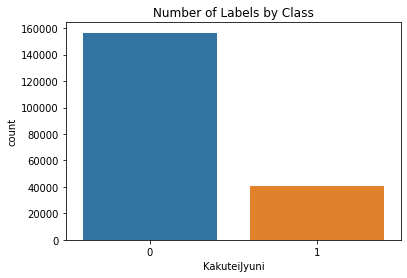

In [155]:
#training model before deployment
def get_training_data_before_deployment( train_data, test_data):
  X_train = train_data.drop(columns='KakuteiJyuni')
  X_test = test_data.drop(columns='KakuteiJyuni')

  y_train = train_data['KakuteiJyuni']
  y_test = test_data['KakuteiJyuni']
  return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = get_training_data_before_deployment(train_data, test_data)
plt.figure(figsize=(6,4))
sns.countplot(y_train)
plt.title('Number of Labels by Class')
y_train.value_counts()

# III. Model training

Ở đây ta vừa training cũng như vừa đánh giá model dựa trên các metrics như precision, recall, f1-score và confusion matrix.

In [57]:
#training with original data
start = time()
d_train = lgb.Dataset(X_train, label = y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['num_leaves'] = 100
params['min_data'] = 500
params['max_depth'] = 100
clf = lgb.train(params, d_train, 100)
end = time()
running_time = end - start
print('time cost: %.5f sec' %running_time)

time cost: 4.45738 sec


In [182]:
#threshold
# y_pred_test = clf_sm.predict(X_test)
# np.count_nonzero(y_pred_test >= 0.5145)
# y_test.value_counts()

755

In [ ]:
def get_binary_output(model,X_test, is_original_data):
  #Prediction
  y_pred = model.predict(X_test)
  #convert into binary values
  if is_original_data:
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.25:       # setting threshold: got 63603 actual 63370 - 0.5347, 0.5261( con odds), 0.5115( bo odds)
            y_pred[i] = 1
        else:  
            y_pred[i] = 0
  if not is_original_data:#over-sampling
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5145:       # setting threshold: got 63603 actual 63370 - 0.5347, 0.5261( con odds), 0.5115( bo odds)
            y_pred[i] = 1
        else:  
            y_pred[i] = 0
  return y_pred
y_pred = get_binary_output(clf, X_test, True)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2763
           1       0.52      0.51      0.51       749

    accuracy                           0.79      3512
   macro avg       0.69      0.69      0.69      3512
weighted avg       0.79      0.79      0.79      3512

[[2406  357]
 [ 366  383]]


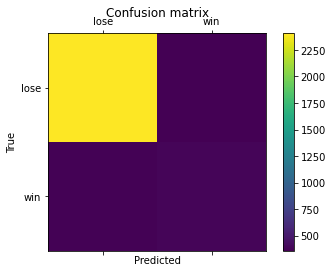

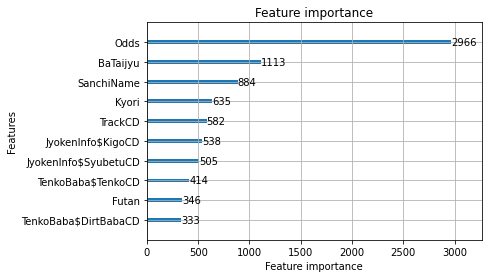

In [78]:
#evaluation
print(classification_report(y_test, y_pred))
#cm, plot
labels = ['lose', 'win']
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# plot model’s feature importances (original data)
lgb.plot_importance(clf, max_num_features=10)

# IV. Model Improvement

In [145]:
#new features
def add_new_date_for_new_features(data):
  data['id$DayMonth'] = 0#reset
  data['id$DayMonthYear'] = 0#reset
  def convert_day_month(MonthDay):
      str_MonthDay = str(MonthDay)
      #TH 1: month(check 2 số đầu, nếu > 12 lấy số index 0, <12 lấy substring index 0&1), Day là phần còn lại -> gán lại cho id$MonthDay
      #TH 2 : khong lay thang 12, 120( 20-1), 110( 10-1)
      if int(str_MonthDay[:2])>12 or (int(str_MonthDay[:2])in [10,11,12] and len(str_MonthDay)==3):
        month_as_string = str_MonthDay[:1]
      else:
        month_as_string = str_MonthDay[:2]
      date_as_string = str_MonthDay[len(month_as_string):]
      day_month = date_as_string + "-" + month_as_string
      return day_month
  data['id$DayMonth'] = data['id$MonthDay'].apply(convert_day_month)
  data['DayMonthYear'] = data[['id$DayMonth', 'id$Year']].astype(str).apply('-'.join, 1)#remove 'id$' due to error at query() statement
  data['YearMonthDay'] = pd.to_datetime(data['DayMonthYear'], format="%d-%m-%Y")#change position of day, month, year to YearMonthDay due to to_datetime
  # print(data.columns.to_list())
  return data
#improvement: create new features( win_per_count_horse, win_per_count_kisyu)
def get_new_features(data):
  data['win_per_count_horse'] = 0.
  data['win_per_count_kisyu'] = 0.
  # print(data.columns.to_list())
  list_dates = (list(data['YearMonthDay'].astype('str'))) # list of race dates.
  indx = 0#indx of current row/ point
  for race_date in list_dates:
    kettoNum = list(data['KettoNum'])[indx]
    kisyuCode = list(data['KisyuCode'])[indx]

    df_match_before_horse = data.query("KettoNum==" + '"' + str(kettoNum) + '"' + " and YearMonthDay<" + '"' + race_date + '"')#giu race_date o string type
    df_match_before_kisyu = data.query("KisyuCode==" + '"' + str(kisyuCode) + '"' + " and YearMonthDay<" + '"' + race_date + '"')

    total_before_horse = df_match_before_horse['KettoNum'].count()
    total_before_kisyu = df_match_before_kisyu['KisyuCode'].count()
    total_win_before_horse = df_match_before_horse.query("KakuteiJyuni in [1,2,3]")['KettoNum'].count()
    total_win_before_kisyu = df_match_before_kisyu.query("KakuteiJyuni in [1,2,3]")['KisyuCode'].count()
    # print(total_before_horse, total_before_kisyu, total_win_before_horse, total_win_before_kisyu)
    data['win_per_count_horse'][indx] = total_win_before_horse/total_before_horse if total_before_horse>0. else 0.#0 khi la tran dau tien
    data['win_per_count_kisyu'][indx] = total_win_before_kisyu/total_before_kisyu if total_before_kisyu>0. else 0.#0 khi la tran dau tien
    # print(data['win_per_count_horse'][indx], data['win_per_count_kisyu'][indx])
    indx+=1
  return data

data = get_data_from_feature_sel_merg(RA, SE, UM_all, CH, KS, True)
data_date = add_new_date_for_new_features(data)
data = get_new_features(data_date)
train_data, test_data, data = get_transformation_and_splitting_dropping( data, True, True)
X_train, X_test, y_train, y_test = get_training_data_before_deployment(train_data, test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [156]:
#handle imbalanced data: over-sampling
sm = SMOTE(random_state=0)
X_sm, y_sm = sm.fit_sample(X_train, y_train)
X_sm = pd.DataFrame(X_sm, columns=list(X_train))#dataframe, columns
X_sm = X_sm.astype(X_train.dtypes)#copy dtypes

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [185]:
#improvement: tuning params
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# Create parameters to search
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and (5000) define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=50)
# Create the grid
grid = GridSearchCV(clf, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
# Run the grid
grid.fit(X_sm, y_sm)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 16, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.4, 'subsample': 0.7}
0.7546642421765936


In [ ]:
start = time()

d_train = lgb.Dataset(X_sm, label = y_sm)
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['colsample_bytree'] = 0.65
params['n_estimators'] = 40
params['random_state'] = 501
params['reg_lambda'] = 1.4
params['subsample'] = 0.7
params['reg_alpha'] = 1
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 16
params['min_data'] = 500
params['max_depth'] = 100
clf_sm = lgb.train(params, d_train, 100)

end = time()
running_time = end - start
print('time cost: %.5f sec' %running_time)
#Prediction
y_pred = get_binary_output(clf_sm, X_test, False)
print(classification_report(y_test, y_pred))
#cm, plot
labels = ['lose', 'win']
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
# plot model’s feature importances (original data)
lgb.plot_importance(clf_sm, max_num_features=10)

Save and load model

In [187]:
#save model: 
import joblib
# save model
joblib.dump(clf_sm, 'clf_sm_nnf.pkl')
# load model
# clf_sm = joblib.load('clf_sm_nnf.pkl')

['clf_sm_nnf.pkl']

V. RESTful API Application.

*Lưu ý: Điều chỉnh đường dẫn phù hợp để chương trình có thể trỏ đúng thư mục như templates giúp hỗ trợ render UI cho ứng dụng.

In [ ]:
#install for flask-ngrok for API
!pip install flask-ngrok

In [ ]:
from flask_ngrok import run_with_ngrok
import io, os
from flask import Flask, request, jsonify, render_template, make_response, send_file
from werkzeug.utils import secure_filename
import csv
import json
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route("/")
def home():
  return render_template('upload.html')
  '''
  For rendering results on HTML GUI
  '''
@app.route('/uploader', methods = ['GET', 'POST'])
def upload_file():
  file_content = ''
  if request.method == 'POST':
      file = request.files['file']
      filename = secure_filename(file.filename) 
      file.save(filename)#save to colab's directory
      unzipFile(filename)
      #load data
      RA = pd.read_pickle('new_race_data/RA2.pickle').reset_index(drop=True)#Race details
      SE = pd.read_pickle('new_race_data/SE2.pickle').reset_index(drop=True)#Horse race information
      UM_all = pd.read_pickle('new_race_data/UM.pickle').reset_index(drop=True)#thông tin con ngựa
      CH = pd.read_pickle('new_race_data/CH.pickle').reset_index(drop=True)#CHOKYO, trainer
      KS = pd.read_pickle('new_race_data/KS.pickle').reset_index(drop=True)#KISYU, người cưỡi ngựa
      #handle data, no rows dropped
      data = get_data_from_feature_sel_merg(RA, SE, UM_all, CH, KS, True)
      data_date = add_new_date_for_new_features(data)#reserve date
      data = get_new_features(data_date)
      train_data, test_data, data = get_transformation_and_splitting_dropping( data, False, True)#no use train_data, test_data. use new df data
      X_pred = data.drop(columns='KakuteiJyuni')
      #Prediction
      y_pred = get_binary_output(clf_sm, X_pred, False)#False: use threshold with oversampling model
      data_date.head(20)
      f = open('output.csv', 'w')
      with f:
          fnames = ['DayMonthYear', 'KettoNum','Umaban','JyoCD','Kaiji','Nichiji','RaceNum','KettoNum','result']
          writer = csv.DictWriter(f, fieldnames=fnames)    
          writer.writeheader()
          for i in range(len(y_pred)):
            writer.writerow({'DayMonthYear': data_date['DayMonthYear'][i], 'KettoNum': data_date['KettoNum'][i], 'Umaban': data_date['Umaban'][i], 'JyoCD': data_date['id$JyoCD'][i], 'Kaiji':  data_date['id$Kaiji'][i], 'Nichiji':  data_date['id$Nichiji'][i], 'RaceNum':  data_date['id$RaceNum'][i], 'result': y_pred[i]})
  return send_file("output.csv", as_attachment=True)
def unzipFile(filename):
  %%time
  !unzip -q "{filename}"
  !rm "{filename}"

app.run()